**DETEKCIJA TABLE UPOTREBOM DEEP LEARNING-A**

1) Podela podataka (train/val/test) na nivou slika

Najpre se svi fajlovi slika iz dataset direktorijuma učitavaju i nasumično dele na training, validation i test skup, pri čemu je podela urađena na nivou slika (ne na nivou patch-eva). Ovo je važno da bi se sprečilo “curenje” informacija: patch-evi generisani iz jedne slike pripadaju uvek istom skupu, pa model ne može indirektno da “vidi” istu sliku u treningu i testu.

2) Generisanje kandidata: klasični X-corner (saddle) detektor

Za svaku sliku, u grayscale domenu se primenjuje klasični detektor X-corner tačaka. Ovaj detektor traži tačke koje imaju “saddle” strukturu intenziteta karakterističnu za preseke linija šahovske mreže. Konkretno:

računa se prvi i drugi izvod slike Sobel operatorom (gradijenti i Hesijan), formira se “saddle score”

S=−det(H)

koji postaje pozitivan na saddle tačkama,
zatim se radi non-maximum suppression (NMS) da ostanu samo lokalni maksimumi (po jedna tačka po preseku),

dodatno se primenjuje filtriranje po jačini gradijenta da se uklone kandidati nastali iz šuma ili ravnih regiona,
broj kandidata se ograničava (npr. max_points) radi brzine.

Rezultat ovog koraka je skup kandidatskih X-corner tačaka (potencijalnih preseka mreže), koji je mnogo manji od prostora cele slike, pa time značajno smanjuje kompleksnost daljih koraka.

3) Izrada patch dataset-a i pseudo-labeling (za obuku DNN)

Pošto nemamo ručno anotirane X-corner tačke, generiše se dataset za obuku neuronske mreže pomoću pseudo-labelovanja. Za svaku kandidat tačku:

Extract patch: izdvaja se mali kvadratni deo slike (image patch) fiksne veličine (npr. 32×32 px) centriran u toj tački.

Pseudo label se dodeljuje kombinacijom dva uslova:

tačka mora biti unutar ground-truth bbox-a table, ali sa marginom (bbox se erodira) kako bi se izbegle ivice/ram table,

patch mora proći jednostavan X-pattern test: prosečne vrednosti četiri kvadranta oko centra treba da imaju “X” raspored.

Ako su oba uslova zadovoljena, patch dobija labelu 1 (validan X-corner), inače labelu 0.

Ovaj postupak se radi posebno za train/val/test skup, tako da CNN trenira na patch-evima izvedenim samo iz train slika, a validira/testira se na patch-evima iz val/test slika.

4) Trening CNN klasifikatora (train), podešavanje (val), evaluacija (test)

Nakon izrade patch dataset-a:

definiše se mala konvoluciona mreža (SmallCNN) koja prima patch dimenzije (1×H×W) i vraća dve klase (x-corner / not x-corner),

model se trenira na train patch-evima koristeći CrossEntropyLoss i Adam optimizer,

zbog klasnog disbalansa (malo pozitivnih u odnosu na negativne), koristi se težinsko balansiranje klasa (veća težina za pozitivnu klasu),

na kraju svake epohe računaju se metrike na train skupu (accuracy, precision, recall) kako bi se pratio trening i izbegao overfitting.

Nakon svake epohe model se evaluira na val patch-evima i na osnovu val metrika (npr. F1, precision/recall) prati se da li model generalizuje ili počinje da overfituje. U okviru grid-search procesa, više kombinacija hiperparametara (npr. learning rate, batch size i sl.) se trenira na training skupu, a zatim se na validacionom skupu bira konfiguracija koja daje najbolji rezultat.
 Pored toga, validacioni skup se koristi i za izbor optimalne epohe (early stopping / najbolji checkpoint) — čuva se model iz epohe u kojoj je val performansa najveća, umesto da se koristi poslednja epoha. Na kraju, pošto izlaz mreže daje verovatnoću da je tačka validan X-corner, validacioni skup se koristi i za podešavanje praga odlučivanja (thr) kojim se filtriraju tačke; prag se bira tako da daje najbolji kompromis između zadržavanja dovoljno tačaka i izbacivanja lažnih detekcija, što se

Nakon završetka treninga, klasifikator se izveštava na test patch-evima (patch-level generalizacija).

5) Inference: DNN filtriranje kandidata u novoj slici

Za detekciju table u slici (posebno na test slikama):

ponovo se generišu kandidatske saddle tačke (X-corner kandidati) klasičnim detektorom,

oko svake kandidat tačke se iseče patch i pusti kroz CNN,

CNN daje verovatnoću da je ta tačka validan X-corner,

zadržavaju se samo tačke čija je verovatnoća iznad praga (npr. thr=0.5).

Ovaj korak uklanja veliki deo lažnih detekcija nastalih od figura, refleksija i teksture stola, i ostavlja čistiji skup tačaka koje zaista liče na preseke mreže.

6) Geometrijska detekcija table: RANSAC + homografija (image → grid)

Preostale tačke (posle DNN filtriranja) ulaze u geometrijski deo:

uzima se konveksni omotač (convex hull) filtriranih tačaka, da bi se birale globalne hipoteze umesto lokalnih,

RANSAC u svakoj iteraciji bira 4 tačke sa hull-a i tretira ih kao kandidat četvorougla unutrašnje 7×7 mreže,

računa se homografija
𝐻
H koja mapira taj četvorougao u idealan grid sistem (0..6),

zatim se sve filtrirane tačke transformišu u grid prostor i proverava se da li padaju blizu integer preseka (0..6), uz toleranciju reprojekcione greške,

score hipoteze je broj unikatnih pogođenih integer preseka (max 49), što favorizuje hipoteze koje objašnjavaju celu mrežu, a ne samo mali deo.

Najbolja hipoteza daje početnu homografiju
𝐻
H i skup inlier tačaka.

7) Refinement homografije (stabilizacija na osnovu inliera)

Da bi se preciznost poboljšala, homografija se rafinira:

uzmu se inlier tačke u slici,

transformišu se u grid prostor i uparuju sa najbližim integer koordinatama,

zatim se ponovo računa homografija pomoću cv2.findHomography sa RANSAC-om,

posle rafiniranja se ponovo izračunavaju score i inlieri strožim pragom.

Ovaj korak “pegla” homografiju i obično poboljšava poravnanje mreže na tabli.

8) Predikcija spoljašnjeg okvira table i perspektivna korekcija

Homografija je definisana kao image → grid, pa se invertuje da bi se idealne grid tačke projektovale nazad u sliku:

koriste se spoljašnje grid koordinate (-1..7) koje odgovaraju kompletnom okviru 8×8 table,

transformacijom preko

H
−1
 dobija se četvorougao u slici koji predstavlja predikovani položaj table,

opcionalno se radi warpPerspective kako bi se dobio top-down prikaz table (homography effect).

9) Evaluacija na test skupu: IoU + brzina + vizualizacije

Na kraju se pipeline pokreće na test slikama i za svaku sliku se računa:

da li je detekcija uspela (has_pred),

vreme detekcije po slici (ms),

IoU između GT maske i predikcione maske (poligon table → maska).

Rezultati se čuvaju u CSV fajl, crta se histogram IoU vrednosti i histogram vremena, i prikazuju se najbolji i najgori primer (GT vs Pred overlay), kao i uticaj homografije kroz:

grid overlay na originalnoj slici,

warped top-down prikaz.

Images found: 329
Split: train=230, val=49, test=50

Building TRAIN patches...
  built 25/230 images | total patches so far: 1747
  built 50/230 images | total patches so far: 3674
  built 75/230 images | total patches so far: 5971
  built 100/230 images | total patches so far: 8305
  built 125/230 images | total patches so far: 10451
  built 150/230 images | total patches so far: 12371
  built 175/230 images | total patches so far: 14652
  built 200/230 images | total patches so far: 16389
  built 225/230 images | total patches so far: 19106
TRAIN patches: (19829, 32, 32) pos rate: 0.5286196984215038

Building VAL patches...
  built 25/49 images | total patches so far: 2341
VAL patches: (4199, 32, 32) pos rate: 0.5579899976184806

Grid search CNN on VAL (early stopping)...

=== CFG === {'lr': 0.001, 'batch_size': 256, 'max_epochs': 20, 'patience': 3}
  ep01 | train F1=0.954 | val F1=0.950 | best=0.950@1
  ep02 | train F1=0.969 | val F1=0.968 | best=0.968@2
  ep03 | train F1=0.961 | va

,lr,batch_size,max_epochs,patience,best_epoch,best_val_f1
0,0.0010,256,20,3,13,0.983276
1,0.0003,256,20,3,6,0.971367


Best config: {'lr': 0.001, 'batch_size': 256, 'max_epochs': 20, 'patience': 3, 'best_epoch': 13, 'best_val_f1': 0.9832761578044598}
Saved best model: /content/xcorner_dnn_best.pt

Tune threshold thr on VAL using BOARD IoU...
  probs stats: min=0.000 max=1.000 mean=0.784 | kept@thr=0.3: 50/63
  probs stats: min=0.000 max=1.000 mean=0.762 | kept@thr=0.3: 51/66
  probs stats: min=0.000 max=1.000 mean=0.749 | kept@thr=0.3: 49/65
  probs stats: min=0.000 max=0.999 mean=0.197 | kept@thr=0.3: 49/253
  probs stats: min=0.000 max=1.000 mean=0.803 | kept@thr=0.3: 48/59
  probs stats: min=0.000 max=1.000 mean=0.772 | kept@thr=0.3: 52/65
  probs stats: min=0.000 max=1.000 mean=0.719 | kept@thr=0.3: 48/66
  probs stats: min=0.000 max=1.000 mean=0.808 | kept@thr=0.3: 49/59
  probs stats: min=0.000 max=1.000 mean=0.819 | kept@thr=0.3: 51/60
  probs stats: min=0.000 max=1.000 mean=0.812 | kept@thr=0.3: 49/59
  probs stats: min=0.000 max=1.000 mean=0.796 | kept@thr=0.3: 49/61
  probs stats: min=0.000 m

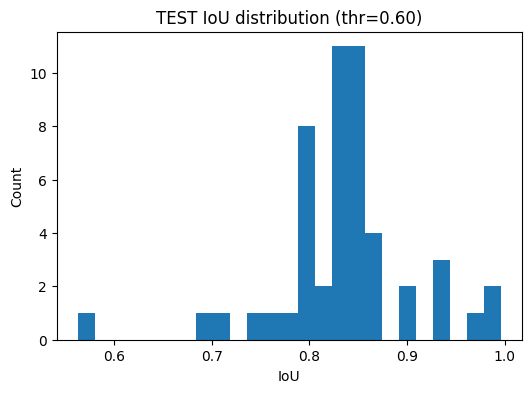

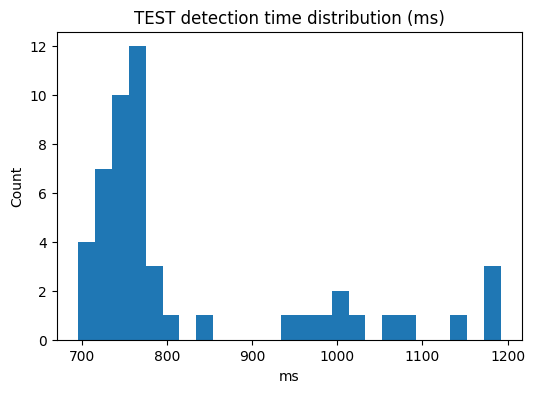

  probs stats: min=0.000 max=0.999 mean=0.185 | kept@thr=0.6: 43/253


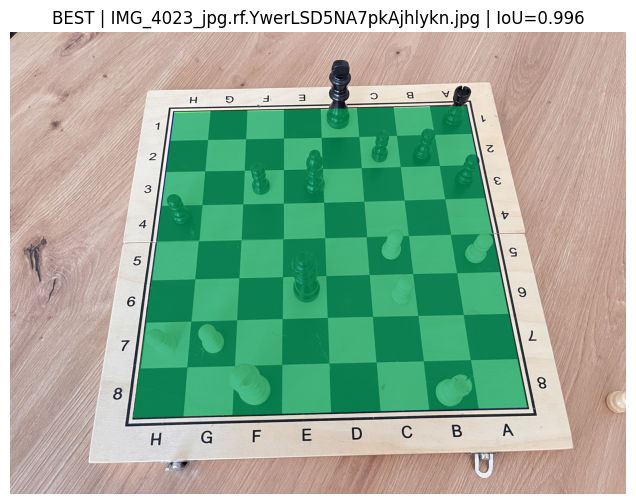

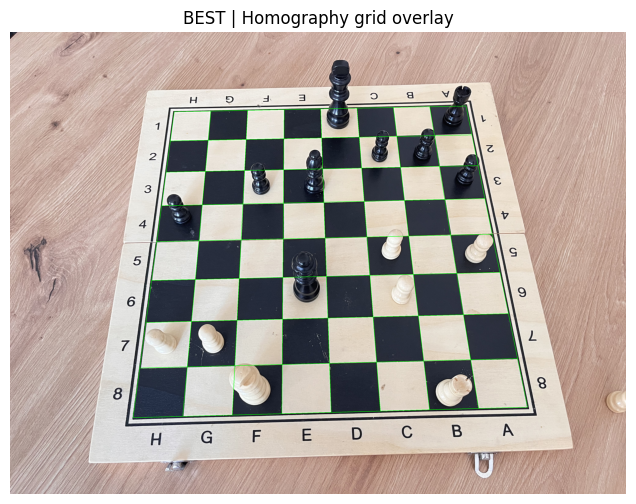

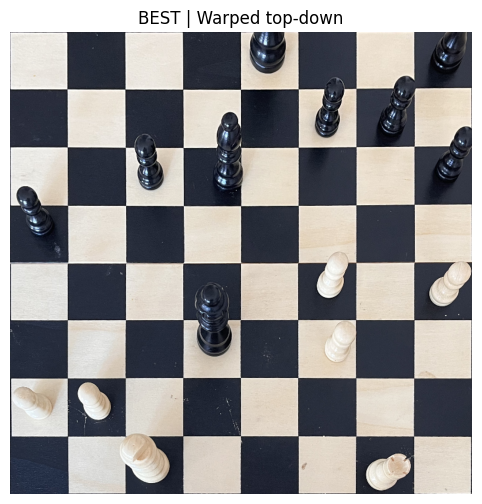

  probs stats: min=0.000 max=0.999 mean=0.136 | kept@thr=0.6: 31/257


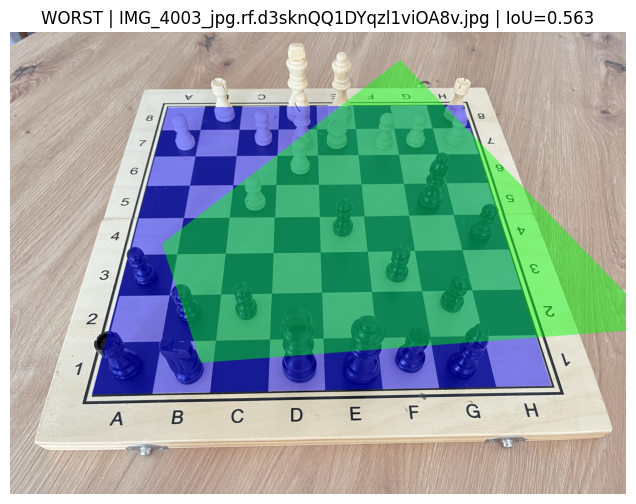

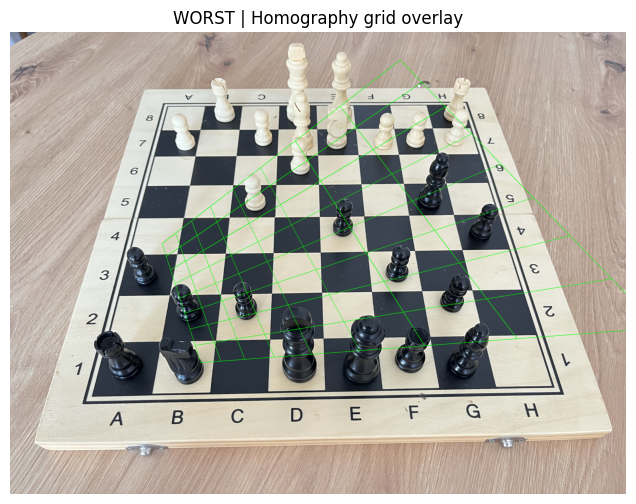

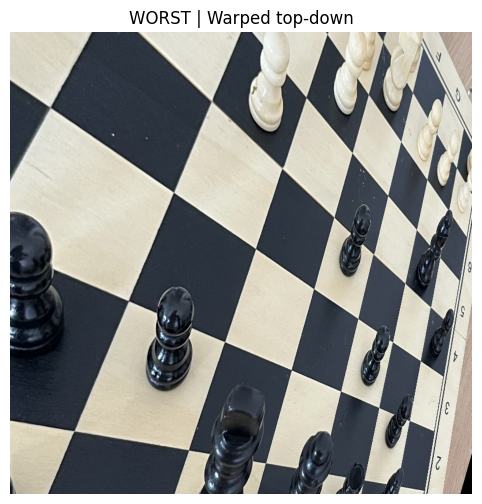

In [6]:
# ============================================================
# FULL PIPELINE (IMAGE-LEVEL train/val/test) + GRID SEARCH on VAL
# - Build pseudo patch datasets per split (no leakage)
# - Grid-search CNN hyperparams using VAL (early stopping + best checkpoint)
# - Tune DNN threshold thr on VAL using BOARD IoU (after RANSAC)
# - Final evaluation on TEST (IoU + timing + best/worst + homography visuals)
# ============================================================

!pip -q install opencv-python-headless matplotlib pandas torch

import os, glob, json, random, time, copy
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# CONFIG
# -----------------------------
DATA_DIR  = "/content/soft-canny"
COCO_PATH = "/content/soft-canny/_annotations.coco.json"
IMG_GLOBS = ["*.jpg","*.jpeg","*.png","*.webp"]

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# split by images (recommended)
TRAIN_FRAC = 0.70
VAL_FRAC   = 0.15
TEST_FRAC  = 0.15

# patches / pseudo-labeling
PATCH_SIZE = 32
BBOX_MARGIN = 20
MAX_PTS_PER_IMAGE = 300

# X-pattern heuristic
PAT_R = 8
PAT_MIN_CONTRAST = 14
PAT_DIAG_TOL = 18

# saddle candidate detector
SADDLE_SCORE_PCTL = 98.8
SADDLE_NMS_WIN = 11
SADDLE_MAX_POINTS = 800

# RANSAC board
RANSAC_ITERS = 5000
RANSAC_MAX_REPROJ = 0.55
RANSAC_MIN_QUAD_AREA_RATIO = 0.22
REFINE_RANSAC_THRESH = 0.9
STRICT_REPROJ = 0.45

# GRID SEARCH space (tune on VAL)
GRID = {
    "lr": [1e-3, 3e-4],
    "batch_size": [256],
    "max_epochs": [20],    # with early stopping
    "patience": [3],
}

# Threshold tuning on VAL for board IoU
THR_GRID = [0.3, 0.4, 0.5, 0.6, 0.7]
VAL_THR_LIMIT_IMAGES = 80  # speed-up

# outputs
OUT_BEST_MODEL = "/content/xcorner_dnn_best.pt"
OUT_THR_TUNING = "/content/val_thr_tuning.csv"
OUT_TEST_IOU_CSV = "/content/iou_results_dnn_ransac_test.csv"

DEBUG_IMAGE_NAME = "IMG_4054_jpg.rf.aoyozh3Urc15bQwhQ8Ox.jpg"  # optional

# -----------------------------
# 0) UTILS
# -----------------------------
def list_images(data_dir):
    paths = []
    for g in IMG_GLOBS:
        paths += glob.glob(os.path.join(data_dir, g))
    return sorted(paths)

def split_images(paths, train_frac=0.7, val_frac=0.15, test_frac=0.15, seed=1):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6
    rng = np.random.default_rng(seed)
    idx = np.arange(len(paths))
    rng.shuffle(idx)
    n = len(paths)
    n_tr = int(n * train_frac)
    n_va = int(n * val_frac)
    tr = [paths[i] for i in idx[:n_tr]]
    va = [paths[i] for i in idx[n_tr:n_tr+n_va]]
    te = [paths[i] for i in idx[n_tr+n_va:]]
    return tr, va, te

def show_rgb(img_bgr, title="", figsize=(10,6)):
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def order_points(pts4):
    pts4 = np.array(pts4, dtype=np.float32)
    s = pts4.sum(axis=1)
    diff = np.diff(pts4, axis=1).reshape(-1)
    tl = pts4[np.argmin(s)]
    br = pts4[np.argmax(s)]
    tr = pts4[np.argmin(diff)]
    bl = pts4[np.argmax(diff)]
    return np.array([tl, tr, br, bl], dtype=np.float32)

def poly_to_mask(poly_xy, h, w):
    mask = np.zeros((h, w), dtype=np.uint8)
    pts = np.round(np.array(poly_xy, dtype=np.float32)).astype(np.int32).reshape(-1,1,2)
    cv2.fillPoly(mask, [pts], 1)
    return mask

def mask_iou(a, b):
    inter = np.logical_and(a > 0, b > 0).sum()
    union = np.logical_or(a > 0, b > 0).sum()
    return float(inter) / float(union) if union > 0 else 0.0

def overlay_masks_on_image(img_bgr, gt_mask, pred_mask, alpha=0.45):
    out = img_bgr.copy().astype(np.float32)
    gt = gt_mask > 0
    pr = pred_mask > 0
    blue  = np.array([255,0,0], dtype=np.float32)
    green = np.array([0,255,0], dtype=np.float32)
    out[gt] = (1-alpha)*out[gt] + alpha*blue
    out[pr] = (1-alpha)*out[pr] + alpha*green
    return out.astype(np.uint8)

def draw_points(img_bgr, pts_xy, color=(0,0,255), r=3):
    out = img_bgr.copy()
    for x,y in pts_xy:
        cv2.circle(out, (int(round(x)), int(round(y))), r, color, 2)
    return out

# -----------------------------
# 1) COCO HELPERS
# -----------------------------
def coco_load(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def build_coco_index(coco):
    id_by_filename = {im["file_name"]: im["id"] for im in coco.get("images", [])}
    ann_by_image = {}
    for ann in coco.get("annotations", []):
        ann_by_image.setdefault(ann["image_id"], []).append(ann)
    return id_by_filename, ann_by_image

def bbox_area_safe(ann):
    b = ann.get("bbox", [0,0,0,0])
    try:
        x,y,w,h = [float(v) for v in b]
    except Exception:
        return 0.0
    a = ann.get("area", None)
    if a is not None:
        try: return float(a)
        except Exception: pass
    return float(w*h)

def pick_gt_board_annotation(anns):
    if not anns:
        return None
    anns_with_seg = [a for a in anns if a.get("segmentation")]
    pool = anns_with_seg if len(anns_with_seg) else anns
    return max(pool, key=bbox_area_safe)

def segmentation_to_mask(segmentation, h, w):
    mask = np.zeros((h, w), dtype=np.uint8)
    if segmentation is None:
        return mask
    for poly in segmentation:
        if poly is None or len(poly) < 6:
            continue
        pts = np.array(poly, dtype=np.float32).reshape(-1,2)
        cv2.fillPoly(mask, [np.round(pts).astype(np.int32)], 1)
    return mask

def bbox_to_mask(bbox_xywh, h, w):
    x,y,bw,bh = [float(v) for v in bbox_xywh]
    x1,y1 = int(round(x)), int(round(y))
    x2,y2 = int(round(x+bw)), int(round(y+bh))
    mask = np.zeros((h,w), dtype=np.uint8)
    mask[max(0,y1):min(h,y2), max(0,x1):min(w,x2)] = 1
    return mask

def get_gt_bbox_for_file(fname, id_by_filename, ann_by_image):
    image_id = id_by_filename.get(fname)
    if image_id is None:
        return None
    anns = ann_by_image.get(image_id, [])
    if not anns:
        return None
    ann = max(anns, key=bbox_area_safe)
    return [float(v) for v in ann["bbox"]]

def get_gt_mask_for_file(fname, img_shape, id_by_filename, ann_by_image):
    h,w = img_shape[:2]
    image_id = id_by_filename.get(fname)
    if image_id is None:
        return None
    anns = ann_by_image.get(image_id, [])
    ann = pick_gt_board_annotation(anns)
    if ann is None:
        return None
    if ann.get("segmentation"):
        return segmentation_to_mask(ann["segmentation"], h, w)
    if ann.get("bbox"):
        return bbox_to_mask(ann["bbox"], h, w)
    return None

# -----------------------------
# 2) SADDLE X-POINT DETECTOR
# -----------------------------
def getSaddle(gray_img, ksize=3):
    img = gray_img.astype(np.float32)
    gx  = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize)
    gy  = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
    gxx = cv2.Sobel(gx,  cv2.CV_32F, 1, 0, ksize=ksize)
    gyy = cv2.Sobel(gy,  cv2.CV_32F, 0, 1, ksize=ksize)
    gxy = cv2.Sobel(gx,  cv2.CV_32F, 0, 1, ksize=ksize)

    S = -(gxx * gyy - gxy * gxy)  # positive for saddle
    denom = (gxx * gyy - gxy * gxy)
    sub_s = np.divide(gy * gxy - gx * gyy, denom, out=np.zeros_like(denom), where=denom!=0)
    sub_t = np.divide(gx * gxy - gy * gxx, denom, out=np.zeros_like(denom), where=denom!=0)
    return S, sub_s, sub_t, gx, gy

def nonmax_suppression(score, win=11):
    k = win if win % 2 == 1 else win + 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    dil = cv2.dilate(score, kernel)
    keep = (score == dil)
    out = np.zeros_like(score)
    out[keep] = score[keep]
    return out

def clipBoundingPoints(pts, img_shape, WINSIZE=10):
    h,w = img_shape[:2]
    x,y = pts[:,0], pts[:,1]
    ok = (x > WINSIZE) & (y > WINSIZE) & (x < (w - WINSIZE - 1)) & (y < (h - WINSIZE - 1))
    return pts[ok]

def getFinalSaddlePoints(gray,
                         blur_ksize=5,
                         sobel_ksize=3,
                         nms_win=11,
                         winsize_edge=10,
                         score_percentile=98.8,
                         max_points=800,
                         min_grad_percentile=70,
                         subpix_clip=0.75):
    if blur_ksize and blur_ksize > 1:
        gray_bl = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    else:
        gray_bl = gray.copy()

    S, sub_s, sub_t, gx, gy = getSaddle(gray_bl, ksize=sobel_ksize)
    S[S < 0] = 0
    S_nms = nonmax_suppression(S, win=nms_win)

    grad = np.sqrt(gx*gx + gy*gy)
    gthr = np.percentile(grad[grad > 0], min_grad_percentile) if np.any(grad > 0) else 0
    S_nms[grad < gthr] = 0

    cand = S_nms[S_nms > 0]
    if cand.size == 0:
        return np.zeros((0,2), dtype=np.float32)

    thr = np.percentile(cand, score_percentile)
    ys, xs = np.where(S_nms >= thr)

    vals = S_nms[ys, xs]
    if vals.size > max_points:
        idx = np.argsort(vals)[::-1][:max_points]
        xs, ys = xs[idx], ys[idx]

    pts = np.stack([xs.astype(np.float32), ys.astype(np.float32)], axis=1)
    off = np.stack([sub_s[ys, xs], sub_t[ys, xs]], axis=1).astype(np.float32)
    off = np.clip(off, -subpix_clip, subpix_clip)
    pts = pts + off
    pts = clipBoundingPoints(pts, gray.shape, WINSIZE=winsize_edge)
    return pts

# -----------------------------
# 3) PATCHES + PSEUDO LABELS
# -----------------------------
def extract_patches(gray, pts_xy, patch_size=32):
    r = patch_size // 2
    patches = []
    kept_pts = []
    h, w = gray.shape[:2]
    for x, y in pts_xy:
        x = int(round(float(x))); y = int(round(float(y)))
        if x-r < 0 or y-r < 0 or x+r >= w or y+r >= h:
            continue
        patch = gray[y-r:y+r, x-r:x+r].astype(np.float32) / 255.0
        patches.append(patch)
        kept_pts.append([x, y])
    if len(patches) == 0:
        return np.zeros((0,patch_size,patch_size), np.float32), np.zeros((0,2), np.float32)
    return np.stack(patches, axis=0), np.array(kept_pts, dtype=np.float32)

def inside_bbox(x, y, bbox, margin=0):
    bx, by, bw, bh = bbox
    x0 = bx + margin; y0 = by + margin
    x1 = bx + bw - margin; y1 = by + bh - margin
    return (x >= x0) and (x <= x1) and (y >= y0) and (y <= y1)

def is_chess_xcorner(gray, x, y, r=8, min_contrast=14, diag_tol=18):
    h, w = gray.shape[:2]
    x = int(round(x)); y = int(round(y))
    if x-r < 0 or y-r < 0 or x+r >= w or y+r >= h:
        return False

    patch = gray[y-r:y+r+1, x-r:x+r+1].astype(np.float32)
    c = r
    cut = max(1, r//4)

    NW = patch[0:c-cut, 0:c-cut].mean()
    NE = patch[0:c-cut, c+cut:].mean()
    SW = patch[c+cut:, 0:c-cut].mean()
    SE = patch[c+cut:, c+cut:].mean()

    if abs(NW - SE) > diag_tol: return False
    if abs(NE - SW) > diag_tol: return False

    d1 = (NW + SE) / 2.0
    d2 = (NE + SW) / 2.0
    if abs(d1 - d2) < min_contrast: return False
    return True

def build_patch_dataset_for_paths(paths, id_by_filename, ann_by_image, progress_every=25):
    X_list, y_list = [], []
    for i, img_path in enumerate(paths, start=1):
        fname = os.path.basename(img_path)
        bbox = get_gt_bbox_for_file(fname, id_by_filename, ann_by_image)
        if bbox is None:
            continue

        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            continue
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        pts = getFinalSaddlePoints(gray,
                                   score_percentile=SADDLE_SCORE_PCTL,
                                   nms_win=SADDLE_NMS_WIN,
                                   max_points=SADDLE_MAX_POINTS)
        if len(pts) == 0:
            continue

        if len(pts) > MAX_PTS_PER_IMAGE:
            sel = np.random.choice(len(pts), size=MAX_PTS_PER_IMAGE, replace=False)
            pts = pts[sel]

        patches, kept_pts = extract_patches(gray, pts, patch_size=PATCH_SIZE)
        if len(patches) == 0:
            continue

        labels = []
        for (x, y) in kept_pts:
            inside = inside_bbox(x, y, bbox, margin=BBOX_MARGIN)
            pat_ok = is_chess_xcorner(gray, x, y, r=PAT_R,
                                      min_contrast=PAT_MIN_CONTRAST, diag_tol=PAT_DIAG_TOL)
            labels.append(1 if (inside and pat_ok) else 0)

        X_list.append(patches)
        y_list.append(np.array(labels, dtype=np.int64))

        if progress_every and (i % progress_every == 0):
            total = sum(a.shape[0] for a in X_list) if X_list else 0
            print(f"  built {i}/{len(paths)} images | total patches so far: {total}")

    if not X_list:
        return np.zeros((0,PATCH_SIZE,PATCH_SIZE), np.float32), np.zeros((0,), np.int64)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

# -----------------------------
# 4) CNN MODEL
# -----------------------------
class PatchDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        x = self.X[i][None, :, :]  # (1,H,W)
        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(self.y[i], dtype=torch.long)
        )

class SmallCNN(nn.Module):
    def __init__(self, patch_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        s = patch_size//2//2//2
        self.fc1 = nn.Linear(64*s*s, 128)
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def eval_counts(model, device, dl):
    model.eval()
    tp=fp=tn=fn=0
    with torch.no_grad():
        for xb,yb in dl:
            xb=xb.to(device); yb=yb.to(device)
            pred = model(xb).argmax(1)
            tp += ((pred==1)&(yb==1)).sum().item()
            tn += ((pred==0)&(yb==0)).sum().item()
            fp += ((pred==1)&(yb==0)).sum().item()
            fn += ((pred==0)&(yb==1)).sum().item()
    return tp, fp, tn, fn

def f1_from_counts(tp, fp, fn):
    prec = tp / max(1, tp+fp)
    rec  = tp / max(1, tp+fn)
    return 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)

def eval_metrics(model, device, dl):
    tp, fp, tn, fn = eval_counts(model, device, dl)
    acc = (tp+tn)/max(1,tp+tn+fp+fn)
    prec = tp/max(1,tp+fp)
    rec = tp/max(1,tp+fn)
    f1 = f1_from_counts(tp, fp, fn)
    return acc, prec, rec, f1

def train_with_early_stopping(patch_size, Xtr,ytr,Xva,yva, lr, batch_size, max_epochs, patience):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SmallCNN(patch_size=patch_size).to(device)

    dl_tr = DataLoader(PatchDS(Xtr,ytr), batch_size=batch_size, shuffle=True, num_workers=0)
    dl_va = DataLoader(PatchDS(Xva,yva), batch_size=batch_size, shuffle=False, num_workers=0)

    # imbalance weights
    pos = (ytr==1).sum(); neg = (ytr==0).sum()
    w_pos = float(neg / max(1,pos))
    class_w = torch.tensor([1.0, w_pos], device=device)
    crit = nn.CrossEntropyLoss(weight=class_w)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_state = None
    best_epoch = -1
    best_val_f1 = -1.0
    bad = 0

    for ep in range(1, max_epochs+1):
        model.train()
        for xb,yb in dl_tr:
            xb=xb.to(device); yb=yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        tr = eval_metrics(model, device, dl_tr)
        va = eval_metrics(model, device, dl_va)

        if va[3] > best_val_f1 + 1e-4:
            best_val_f1 = va[3]
            best_epoch = ep
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1

        print(f"  ep{ep:02d} | train F1={tr[3]:.3f} | val F1={va[3]:.3f} | best={best_val_f1:.3f}@{best_epoch}")
        if bad >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, device, {"best_epoch": best_epoch, "best_val_f1": best_val_f1}

def grid_search_cnn(Xtr,ytr,Xva,yva):
    results = []
    best = None
    best_state = None
    best_device = None

    for lr in GRID["lr"]:
        for bs in GRID["batch_size"]:
            for max_ep in GRID["max_epochs"]:
                for pat in GRID["patience"]:
                    print("\n=== CFG ===", {"lr":lr,"batch_size":bs,"max_epochs":max_ep,"patience":pat})
                    model, device, info = train_with_early_stopping(
                        PATCH_SIZE, Xtr,ytr, Xva,yva,
                        lr=lr, batch_size=bs, max_epochs=max_ep, patience=pat
                    )
                    cfg = {"lr":lr,"batch_size":bs,"max_epochs":max_ep,"patience":pat, **info}
                    results.append(cfg)

                    if best is None or cfg["best_val_f1"] > best["best_val_f1"]:
                        best = cfg
                        best_state = copy.deepcopy(model.state_dict())
                        best_device = device

    df = pd.DataFrame(results).sort_values("best_val_f1", ascending=False)
    return df, best, best_state, best_device

def load_model_from_state(state_dict, device):
    model = SmallCNN(patch_size=PATCH_SIZE).to(device)
    model.load_state_dict(state_dict)
    return model

# -----------------------------
# 5) DNN FILTER
# -----------------------------
def filter_points_with_dnn(img_bgr, pts_xy, model, device, thr=0.5):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    patches, kept_pts = extract_patches(gray, pts_xy, patch_size=PATCH_SIZE)
    if len(patches) == 0:
        return np.zeros((0,2), np.float32), np.zeros((0,), np.float32)

    # FIX: dtype keyword argument
    xb = torch.tensor(patches[:,None,:,:], dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(xb), dim=1)[:,1].cpu().numpy()

    # DIJAGNOSTIKA (obriši posle)
    print(f"  probs stats: min={probs.min():.3f} max={probs.max():.3f} "
          f"mean={probs.mean():.3f} | kept@thr={thr}: {(probs>=thr).sum()}/{len(probs)}")

    keep = probs >= thr
    return kept_pts[keep], probs

# -----------------------------
# 6) RANSAC + HOMOGRAPHY BOARD
# -----------------------------
def count_hits_on_grid(grid_xy):
    rounded = np.rint(grid_xy).astype(np.int32)
    in_bounds = (rounded[:,0]>=0)&(rounded[:,0]<=6)&(rounded[:,1]>=0)&(rounded[:,1]<=6)
    rounded = rounded[in_bounds]
    if len(rounded)==0:
        return 0
    uniq = set((p[0],p[1]) for p in rounded)
    return len(uniq)

def score_H(H, pts_xy, max_reproj_err=0.55):
    pts = np.array(pts_xy, dtype=np.float32).reshape(-1,1,2)
    grid = cv2.perspectiveTransform(pts, H).reshape(-1,2)
    nearest = np.rint(grid)
    err = np.linalg.norm(grid - nearest, axis=1)
    in_bounds = (nearest[:,0]>=0)&(nearest[:,0]<=6)&(nearest[:,1]>=0)&(nearest[:,1]<=6)
    inliers = (err < max_reproj_err) & in_bounds
    score = count_hits_on_grid(grid[inliers])
    return score, inliers

def ransac_chessboard_from_hull(pts_xy, iters=5000, max_reproj_err=0.55, min_quad_area_ratio=0.22, seed=1):
    rng = np.random.default_rng(seed)
    pts_xy = np.array(pts_xy, dtype=np.float32)
    if len(pts_xy) < 20:
        raise ValueError("Premalo X-points.")

    hull = cv2.convexHull(pts_xy.reshape(-1,1,2)).reshape(-1,2)
    if len(hull) < 4:
        raise ValueError("Hull premali.")

    hull_area = cv2.contourArea(hull.reshape(-1,1,2))
    min_area = max(1.0, min_quad_area_ratio * hull_area)

    dst = np.array([[0,0],[6,0],[6,6],[0,6]], dtype=np.float32)
    best = {"score":-1,"H":None,"quad_xy":None,"inliers":None}

    for _ in range(iters):
        idx = rng.choice(len(hull), size=4, replace=False)
        quad = order_points(hull[idx])
        area = cv2.contourArea(quad.reshape(-1,1,2))
        if area < min_area:
            continue
        H = cv2.getPerspectiveTransform(quad, dst)
        score, inliers = score_H(H, pts_xy, max_reproj_err=max_reproj_err)
        if score > best["score"]:
            best.update({"score":score,"H":H,"quad_xy":quad,"inliers":inliers})
    if best["H"] is None:
        raise ValueError("RANSAC fail.")
    return best

def refine_homography(best, pts_xy, ransac_thresh=0.9, strict_reproj=0.45):
    pts_xy = np.array(pts_xy, dtype=np.float32)
    inlier_img = pts_xy[best["inliers"]]
    if len(inlier_img) < 8:
        return best

    grid = cv2.perspectiveTransform(inlier_img.reshape(-1,1,2), best["H"]).reshape(-1,2)
    grid_int = np.rint(grid).astype(np.float32)

    mask_ok = (grid_int[:,0]>=0)&(grid_int[:,0]<=6)&(grid_int[:,1]>=0)&(grid_int[:,1]<=6)
    inlier_img2 = inlier_img[mask_ok]
    grid_int2 = grid_int[mask_ok]
    if len(inlier_img2) < 8:
        return best

    H_ref, _ = cv2.findHomography(inlier_img2, grid_int2, method=cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
    if H_ref is not None:
        best["H"] = H_ref

    score_ref, inliers_ref = score_H(best["H"], pts_xy, max_reproj_err=strict_reproj)
    best["score"] = score_ref
    best["inliers"] = inliers_ref
    return best

def predict_board_polygon(img_bgr, model, device, thr=0.5):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    pts0 = getFinalSaddlePoints(gray, score_percentile=SADDLE_SCORE_PCTL, nms_win=SADDLE_NMS_WIN, max_points=SADDLE_MAX_POINTS)
    pts1, _ = filter_points_with_dnn(img_bgr, pts0, model, device, thr=thr)
    if len(pts1) < 20:
        raise ValueError("premalo_filtriranih")

    best = ransac_chessboard_from_hull(pts1, iters=RANSAC_ITERS, max_reproj_err=RANSAC_MAX_REPROJ,
                                       min_quad_area_ratio=RANSAC_MIN_QUAD_AREA_RATIO, seed=SEED)
    best = refine_homography(best, pts1, ransac_thresh=REFINE_RANSAC_THRESH, strict_reproj=STRICT_REPROJ)

    H_grid2img = np.linalg.inv(best["H"]).astype(np.float32)
    outer_grid = np.array([[-1,-1],[7,-1],[7,7],[-1,7]], dtype=np.float32).reshape(-1,1,2)
    outer_img = cv2.perspectiveTransform(outer_grid, H_grid2img).reshape(-1,2)
    return outer_img, best, pts0, pts1

def draw_full_board_grid(img_bgr, H_img2grid, thickness=2):
    out = img_bgr.copy()
    H_grid2img = np.linalg.inv(H_img2grid)
    for k in range(-1, 8):
        v = np.array([[k,-1],[k,7]], np.float32).reshape(-1,1,2)
        h = np.array([[-1,k],[7,k]], np.float32).reshape(-1,1,2)
        v_img = cv2.perspectiveTransform(v, H_grid2img).reshape(-1,2)
        h_img = cv2.perspectiveTransform(h, H_grid2img).reshape(-1,2)
        cv2.line(out, tuple(v_img[0].astype(int)), tuple(v_img[1].astype(int)), (0,255,0), thickness)
        cv2.line(out, tuple(h_img[0].astype(int)), tuple(h_img[1].astype(int)), (0,255,0), thickness)
    return out

def warp_full_board(img_bgr, H_img2grid, out_size=800):
    outer_grid = np.array([[-1,-1],[7,-1],[7,7],[-1,7]], np.float32).reshape(-1,1,2)
    H_grid2img = np.linalg.inv(H_img2grid)
    outer_img = cv2.perspectiveTransform(outer_grid, H_grid2img).reshape(-1,2).astype(np.float32)
    dst = np.array([[0,0],[out_size-1,0],[out_size-1,out_size-1],[0,out_size-1]], np.float32)
    H_img2top = cv2.getPerspectiveTransform(outer_img, dst)
    return cv2.warpPerspective(img_bgr, H_img2top, (out_size, out_size))

# -----------------------------
# 7) THRESHOLD TUNING ON VAL (BOARD IoU)
# -----------------------------
def tune_thr_on_val(val_paths, model, device, id_by_filename, ann_by_image,
                    thr_grid=(0.3,0.4,0.5,0.6,0.7), limit_images=80):
    rows = []
    sub = val_paths[:min(limit_images, len(val_paths))]

    for thr in thr_grid:
        ious = []
        succ = 0
        used = 0
        for p in sub:
            fname = os.path.basename(p)
            img = cv2.imread(p)
            if img is None:
                continue
            gt = get_gt_mask_for_file(fname, img.shape, id_by_filename, ann_by_image)
            if gt is None:
                continue
            used += 1
            try:
                pred_poly, best, _, _ = predict_board_polygon(img, model, device, thr=thr)
                pr = poly_to_mask(pred_poly, img.shape[0], img.shape[1])
                ious.append(mask_iou(gt, pr))
                succ += 1
            except Exception:
                ious.append(0.0)
        miou = float(np.mean(ious)) if len(ious) else 0.0
        sr = succ / max(1, used)
        rows.append({"thr": thr, "val_mean_iou": miou, "success_rate": sr, "used": used})
        print(f"thr={thr:.2f} | val mean IoU={miou:.3f} | success={sr:.3f} | used={used}")

    df = pd.DataFrame(rows).sort_values("val_mean_iou", ascending=False)
    return df, df.iloc[0].to_dict()

# -----------------------------
# 8) FINAL TEST EVAL (BOARD IoU)
# -----------------------------
def eval_board_on_test(test_paths, model, device, thr, id_by_filename, ann_by_image, out_csv):
    rows = []
    t_all0 = time.perf_counter()

    for i, p in enumerate(test_paths, start=1):
        fname = os.path.basename(p)
        img = cv2.imread(p)
        if img is None:
            continue
        gt = get_gt_mask_for_file(fname, img.shape, id_by_filename, ann_by_image)
        if gt is None:
            continue

        t0 = time.perf_counter()
        try:
            pred_poly, best, _, _ = predict_board_polygon(img, model, device, thr=thr)
            pr = poly_to_mask(pred_poly, img.shape[0], img.shape[1])
            iou = mask_iou(gt, pr)
            status = "ok"
            has_pred = True
        except Exception as e:
            iou = 0.0
            status = f"pred_error:{type(e).__name__}"
            has_pred = False
            best = None

        det_ms = (time.perf_counter() - t0) * 1000.0
        rows.append({"file": fname, "iou": iou, "status": status, "has_pred": has_pred, "det_ms": det_ms})

        if i % 10 == 0:
            ok_ious = [r["iou"] for r in rows if r["status"]=="ok"]
            print(f"[{i}/{len(test_paths)}] mean IoU so far: {np.mean(ok_ious):.3f}")

    total_s = time.perf_counter() - t_all0
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print("Saved:", out_csv)
    return df, total_s

# ============================================================
# RUN
# ============================================================
paths_all = list_images(DATA_DIR)
print("Images found:", len(paths_all))

coco = coco_load(COCO_PATH)
id_by_filename, ann_by_image = build_coco_index(coco)

train_paths, val_paths, test_paths = split_images(paths_all, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, seed=SEED)
print(f"Split: train={len(train_paths)}, val={len(val_paths)}, test={len(test_paths)}")

print("\nBuilding TRAIN patches...")
Xtr, ytr = build_patch_dataset_for_paths(train_paths, id_by_filename, ann_by_image)
print("TRAIN patches:", Xtr.shape, "pos rate:", float(ytr.mean()) if len(ytr) else None)

print("\nBuilding VAL patches...")
Xva, yva = build_patch_dataset_for_paths(val_paths, id_by_filename, ann_by_image)
print("VAL patches:", Xva.shape, "pos rate:", float(yva.mean()) if len(yva) else None)

print("\nGrid search CNN on VAL (early stopping)...")
df_grid, best_cfg, best_state, best_device = grid_search_cnn(Xtr,ytr,Xva,yva)
display(df_grid.head(10))
print("Best config:", best_cfg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = load_model_from_state(best_state, device)
torch.save({"state_dict": best_model.state_dict(), "patch_size": PATCH_SIZE, "best_cfg": best_cfg}, OUT_BEST_MODEL)
print("Saved best model:", OUT_BEST_MODEL)

print("\nTune threshold thr on VAL using BOARD IoU...")
df_thr, best_thr = tune_thr_on_val(val_paths, best_model, device, id_by_filename, ann_by_image,
                                   thr_grid=THR_GRID, limit_images=VAL_THR_LIMIT_IMAGES)
df_thr.to_csv(OUT_THR_TUNING, index=False)
print("Saved:", OUT_THR_TUNING)
print("Best thr row:", best_thr)
chosen_thr = float(best_thr["thr"])

print("\nFinal TEST evaluation (board IoU)...")
df_test, total_s = eval_board_on_test(test_paths, best_model, device, chosen_thr,
                                      id_by_filename, ann_by_image, OUT_TEST_IOU_CSV)

ok = df_test[df_test["status"]=="ok"]
print("\n--- TEST SUMMARY ---")
print("N images:", len(df_test), "| ok:", len(ok), "| has_pred mean:", df_test["has_pred"].mean())
print(f"Total time: {total_s:.2f}s | Avg: {1000*total_s/max(1,len(df_test)):.2f} ms/image")
if len(ok):
    print("Mean IoU:", ok["iou"].mean())
    print("Median IoU:", ok["iou"].median())
    print("Min IoU:", ok["iou"].min())
    print("Max IoU:", ok["iou"].max())

# plots
if len(ok):
    plt.figure(figsize=(6,4))
    plt.hist(ok["iou"], bins=25)
    plt.title(f"TEST IoU distribution (thr={chosen_thr:.2f})")
    plt.xlabel("IoU"); plt.ylabel("Count")
    plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_test["det_ms"].dropna(), bins=25)
plt.title("TEST detection time distribution (ms)")
plt.xlabel("ms"); plt.ylabel("Count")
plt.show()

# best/worst visuals on TEST
if len(ok) >= 2:
    paths_map = {os.path.basename(p): p for p in paths_all}
    best_row = ok.sort_values("iou", ascending=False).iloc[0]
    worst_row = ok.sort_values("iou", ascending=True).iloc[0]

    for tag, row in [("BEST", best_row), ("WORST", worst_row)]:
        fname = row["file"]
        img = cv2.imread(paths_map[fname])
        gt = get_gt_mask_for_file(fname, img.shape, id_by_filename, ann_by_image)
        pred_poly, bestH, pts0, pts1 = predict_board_polygon(img, best_model, device, thr=chosen_thr)
        pr = poly_to_mask(pred_poly, img.shape[0], img.shape[1])
        overlay = overlay_masks_on_image(img, gt, pr, alpha=0.45)
        show_rgb(overlay, f"{tag} | {fname} | IoU={row['iou']:.3f}")

        grid_overlay = draw_full_board_grid(img, bestH["H"])
        show_rgb(grid_overlay, f"{tag} | Homography grid overlay")

        warped = warp_full_board(img, bestH["H"], out_size=800)
        show_rgb(warped, f"{tag} | Warped top-down")

# optional debug image if in test
if DEBUG_IMAGE_NAME in set(df_test["file"].tolist()):
    paths_map = {os.path.basename(p): p for p in paths_all}
    img = cv2.imread(paths_map[DEBUG_IMAGE_NAME])
    gt = get_gt_mask_for_file(DEBUG_IMAGE_NAME, img.shape, id_by_filename, ann_by_image)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pts0 = getFinalSaddlePoints(gray, score_percentile=SADDLE_SCORE_PCTL, nms_win=SADDLE_NMS_WIN, max_points=SADDLE_MAX_POINTS)
    show_rgb(draw_points(img, pts0, color=(0,0,255)), "Raw saddle candidates (red)")

    pts1, probs = filter_points_with_dnn(img, pts0, best_model, device, thr=chosen_thr)
    show_rgb(draw_points(img, pts1, color=(0,255,0)), f"After DNN filtering (green) kept={len(pts1)}")

    pred_poly, bestH, _, _ = predict_board_polygon(img, best_model, device, thr=chosen_thr)
    pr = poly_to_mask(pred_poly, img.shape[0], img.shape[1])
    iou = mask_iou(gt, pr)
    show_rgb(overlay_masks_on_image(img, gt, pr, alpha=0.45), f"GT vs Pred | IoU={iou:.3f}")
    show_rgb(draw_full_board_grid(img, bestH["H"]), "Homography grid overlay")
    show_rgb(warp_full_board(img, bestH["H"], out_size=800), "Warped top-down")

**Analiza greške**

Model pokazuje visoku preciznost lokalizacije table na većini test slika. Histogram IoU vrednosti je koncentrisan oko 0.80–0.87, uz značajan broj primera preko 0.90, što ukazuje da predikovani poligon u najvećem broju slučajeva dobro prati ground-truth konturu table. Najbolji primer dodatno potvrđuje kvalitet: za sliku IMG_4023… postignut je IoU = 0.996, a “homography grid overlay” skoro savršeno leži na mreži polja. Takođe, “warped top-down” prikaz daje stabilno ispravljenu tablu, što znači da je procenjena homografija geometrijski konzistentna i upotrebljiva za naredne korake (npr. analiziranje polja ili detekciju figura u standardizovanom prikazu).

Sa aspekta efikasnosti, histogram vremena pokazuje da se detekcija najčešće izvršava oko ~700–800 ms po slici, uz manji broj sporijih slučajeva koji idu do približno ~1100–1200 ms. Ovaj “rep” je očekivan kod RANSAC-baziranih metoda, jer vreme zavisi od broja preostalih tačaka nakon filtriranja i od toga koliko brzo RANSAC pronađe stabilnu hipotezu (u težim scenama potrebne su dodatne iteracije i više provera inliera).

Sveukupno, rezultati pokazuju da DNN filtriranje značajno pomaže stabilnosti X-points pristupa: u velikom broju slučajeva dobija se precizna homografija (potvrđeno grid overlay-om i top-down warp-om), uz razumno vreme izvršavanja. Preostale greške se uglavnom svode na situacije gde filtriranje nije dovoljno eliminisalo lažne preseke ili gde je mreža table delimično degradirana uslovima snimanja, pa RANSAC proceni suboptimalnu homografiju.